In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

Here, we generate a random sequency of numbers to learn. 

In [2]:

mu1 = 15 # mean prior to change point
mu2 = 5 # mean following change point
stdev = 3
N = 50

X = np.random.normal(mu1, stdev, N)
Y = np.random.normal(mu2, stdev, N)

We train a simple delta rule model to learn the values with fixed weights. The learner updates its estimate after each time point as follows:
$$ V_{t+1} = V_{t} + \eta \left (X_t - V_{t} \right ) $$
where $\eta$ is the learning rate. Note, for the special case that $\eta =\frac{1}{t}$, that the estimate $V$ is equal to the simple average, or $V=\frac{1}{N}\sum_{t=1}{N}X_t$

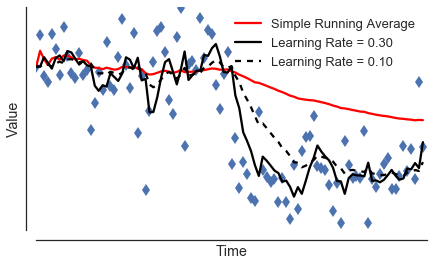

In [3]:

# set the learning rates of the models!
learning_rate0 = 0.3
learning_rate1 = 0.1

# create a simple RL Agent
XY = np.concatenate([X, Y])
mle = [np.mean(XY[0:ii]) for ii in range(1, len(XY) + 1)]

v = X[0]
q = []
for X0 in XY:
    q.append(v)
    v += learning_rate0 *(X0 - v)

v = X[0]
q2 = []
for X0 in XY:
    q2.append(v)
    v += learning_rate1 *(X0 - v)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    plt.plot(XY, 'd')
    plt.plot(mle, 'r', label='Simple Running Average')
    plt.plot(q, 'k', label='Learning Rate = %.2f' % learning_rate0)
    plt.plot(q2, 'k--', label='Learning Rate = %.2f' % learning_rate1)
    ax = plt.gca()
    lb, ub = ax.get_ylim()
    ax.set_ylim([0, ub])
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    plt.legend()

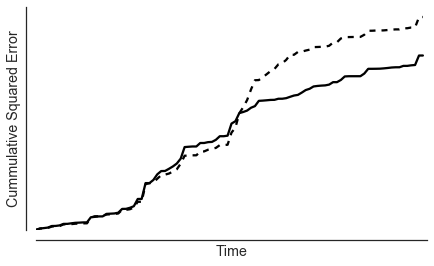

In [4]:
ml_error = []
q_error = []
q2_error = []

for ii, X0 in enumerate(XY):
    ml_error.append((X0-mle[ii])**2)
    q_error.append((X0-q[ii])**2)
    q2_error.append((X0-q2[ii])**2)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    plt.plot(np.cumsum(q_error), 'k', label='Learning Rate = %.2f' % learning_rate0)
    plt.plot(np.cumsum(q2_error), 'k--', label='Learning Rate = %.2f' % learning_rate1)
    ax = plt.gca()
    ax.set_yticks([])
    ax.set_ylabel('Cummulative Squared Error')
    ax.set_xticks([])
    ax.set_xlabel('Time')
    sns.despine(trim=True, offset=10)
    plt.savefig('D8.png', dpi=300)

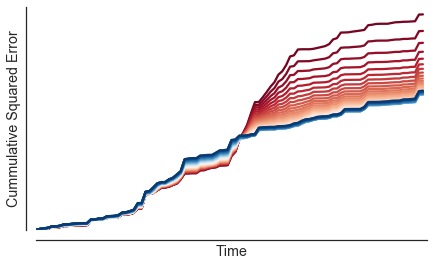

In [5]:

etas =  np.arange(0.05, 0.51, 0.01)

CC = sns.color_palette('RdBu', len(etas)) 
with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))

    for ii, eta in enumerate(etas):
        q_error = []
        v = 15
        for X0 in XY:
            q_error.append((X0-v)**2)
            v += eta *(X0 - v)
        plt.plot(np.cumsum(q_error), color=CC[ii])
        
    ax = plt.gca()
    ax.set_yticks([])
    ax.set_ylabel('Cummulative Squared Error')
    ax.set_xticks([]) 
    ax.set_xlabel('Time')
    fig = plt.gcf()
#     cax = fig.add_axes([1, 0.25, 0.02, 0.5])

    sns.despine(trim=True, offset=10)


# Learning rate as forgetting
A higher learning rate weights more recent experiences more strongly and decays experiences more distant in time more quickly. Specifically, the contribution (weight) of an observation to an learned value is at time $t-k$ is equal to

$$ w(X_{t-k}) = \eta(1-\eta)^{k} $$

This can be shown be unraveling the learning rule as a recursive sum:
$$ V_{t+1} = V_{t} + \eta \left (X_t - V_{t} \right ) $$
$$ V_{t+1} =  \eta X_{t} + \left (1 - \eta \right ) V_{t} $$ 
$$ V_{t+1} =  \eta X_{t} + \left (1 - \eta \right ) \left( \eta X_{t-1} + \left (1 - \eta \right ) V_{t_t-1}\right ) $$ 
$$ V_{t+1} =  \eta X_{t} + \eta\left (1 - \eta \right ) X_{t-1} + \left (1 - \eta \right ) V_{t_t-1} $$ 
$$ V_{t+1} =  \eta X_{t} + \eta\left (1 - \eta \right ) X_{t-1} + \eta\left (1 - \eta \right )^2 X_{t-2} +  \eta\left (1 - \eta \right )^3 X_{t-3} + ... $$ 
$$ V_{t+1} = \sum_{k=0}^{\infty}\eta\left (1 - \eta \right )^k X_{t-k} $$ 


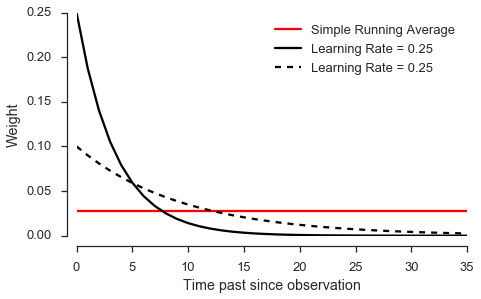

In [6]:
def weight(eta, k):
    return eta * ((1-eta)**k)


with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    x = range(36)
    ax = plt.gca()
    ax.plot(x, np.ones(len(x))/len(x), 'r', label='Simple Running Average')
    ax.plot(x, [weight(0.25, k) for k in x],'k', label='Learning Rate = 0.25')
    ax.plot(x, [weight(0.1, k) for k in x],'k--', label='Learning Rate = 0.25')


    plt.legend()
    
    ax.set_ylabel('Weight')
    ax.set_xlabel('Time past since observation')
    sns.despine(trim=True, offset=10)


# The optimal thing to do after a change point, is to reset and start over

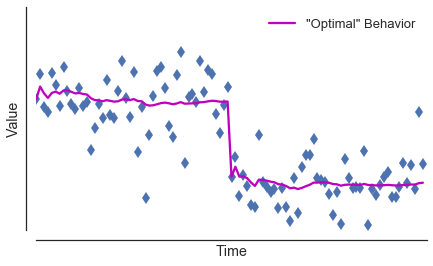

In [7]:
# create a simple RL Agent
XY = np.concatenate([X, Y])
mle = [
    np.mean(X[0:ii]) for ii in range(1, len(X) + 1)] + [np.mean(Y[0:ii]) for ii in range(1, len(Y) + 1)]



v = 10
eta = 0.25
q = []
for X0 in XY:
    q.append(v)
    v += eta *(X0 - v)
    

with sns.axes_style('ticks'):
    plt.figure(figsize=(7, 4))
    plt.plot(XY, 'd')
    plt.plot(mle, 'm', label='"Optimal" Behavior')
#     plt.plot(q, 'k', label='Learning Rate = 0.25')
    ax = plt.gca()
    ax.set_ylim([0, 25])
    ax.set_yticks([])
    ax.set_xticks([])
    sns.despine(trim=True, offset=10)
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    plt.legend()


Here is a demonstration of what a Bayesian learner learning the probability of a binary reward (Bernoulli random variable). This can be parameterized with a Beta distribution with two parameters: "a" the number of sucesses and "b" the number of failures

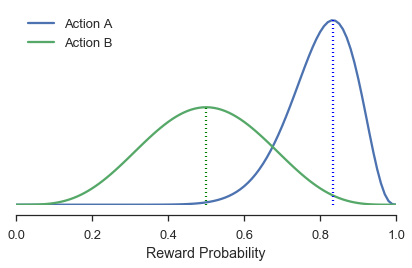

In [8]:
from scipy.stats import beta


a = 16  # number of times option A was tried & rewarded
b = 4  # number of times option A was tried & not rewarded
mode_a = (a - 1.) / (a + b -2.)
rv = beta(a, b)


a = 5 # number of times option A was tried & rewarded
b = 5 # number of times option B was tried & not rewarded
mode_b = (a - 1.) / (a + b -2.)
rv2 = beta(a, b)

x = np.arange(0, 1.01, 0.01)
with sns.axes_style('ticks'):
    plt.figure(figsize=(6, 4))
    plt.plot(x, rv.pdf(x), label='Action A')
    plt.plot(x, rv2.pdf(x), label='Action B')
    
    ax = plt.gca()
    lb, ub = ax.get_ylim()
    plt.plot([mode_a, mode_a], [lb, rv.pdf(mode_a)], 'b:')

    plt.plot([mode_b, mode_b], [lb, rv2.pdf(mode_b)], 'g:')

    
    ax.set_yticks([])
    ax.set_xlabel('Reward Probability')
    sns.despine(offset=10, left=True)
    plt.legend(loc='upper left')
    plt.tight_layout()


The probability that "A" or "B" can be dervied via integration or sampleing. Here, we use sampling

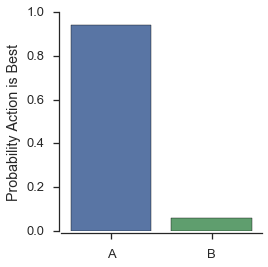

In [9]:
cmf = rv.cdf(x)
cmf2 = rv2.cdf(x)

y = [x[np.sum(cmf < np.random.rand())] > x[np.sum(cmf2 < np.random.rand())] for _ in range(1000)]

with sns.axes_style('ticks'):
    plt.figure(figsize=(4,4))
    sns.barplot([1, 2], [np.sum(y)*1./len(y), (len(y) - np.sum(y))*1./len(y)])
    
    ax = plt.gca()
    ax.set_xticklabels(['A', 'B'])
    ax.set_ylabel('Probability Action is Best')
    ax.set_ylim(0, 1)
    sns.despine(offset=2)
    plt.tight_layout()
